In [162]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os
from matplotlib import pyplot as plt
import spikeinterface as si
import seaborn as sns
import pandas as pd
import numpy as np

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.postpro.cell_matching import get_SpikeInterface_matching_object
from src.nodes.postpro.spike_stats import get_firing_rates


# SET RUN
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"


# SET RUN CONFIG
data_conf, _ = get_config(EXPERIMENT, SIMULATION_DATE).values()


# SET PATHS

# set Kilosort sorted spikes and cells path
KS3_SORTING_PATH = data_conf["sorting"]["sorters"]["kilosort3"]["output"]

# set ground truth spikes and cells path
GT_SORTING_PATH = data_conf["sorting"]["simulation"]["ground_truth"]["output"]

# set recording path
RECORDING_PATH = data_conf["preprocessing"]["output"]["trace_file_path"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-06-05 15:06:52,209 - root - utils.py - get_config - INFO - Reading experiment config.
2023-06-05 15:06:52,254 - root - utils.py - get_config - INFO - Reading experiment config. - done


In [32]:
# true unit agreement score vs. true unit firing rate

# get true units agreement scores (accuracy scores)
MatchingObject = get_SpikeInterface_matching_object(GT_SORTING_PATH, KS3_SORTING_PATH)
score_matrix = MatchingObject.agreement_scores
score = score_matrix.max(axis=1)
score

# get firing rates
Recording = si.load_extractor(RECORDING_PATH)
Truth = si.load_extractor(GT_SORTING_PATH)
rates = get_firing_rates(Truth, Recording)

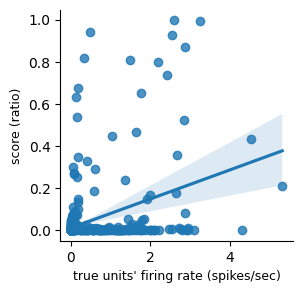

In [116]:
# get score by rate dataframe
fig, ax = plt.subplots(1,1,figsize=(3,3))
score_df = pd.DataFrame(score, columns=["score"])
score_df.index_name="cells"
score_df["cells"] = score_df.index
score_by_rates = rates.merge(score_df, on="cells")

ax = sns.regplot(x="firing rate", y="score", data=score_by_rates, marker="o");
ax.spines[["right", "top"]].set_visible(False)
ax.set_xlabel("true units' firing rate (spikes/sec)", fontsize=9);
ax.set_ylabel("score (ratio)", fontsize=9);

In [159]:
score_by_rates.groupby("firing rate").count().head(27)

,cells,score
firing rate,,
0.001818,56,56
0.003636,36,36
0.005455,17,17
0.007273,19,19
0.009091,13,13
0.010909,12,12
0.012728,13,13
0.014546,13,13
0.016364,6,6


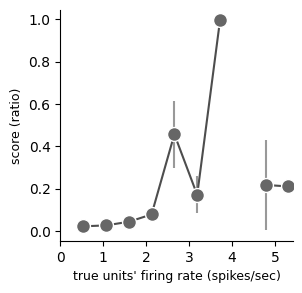

In [260]:
fig, ax = plt.subplots(1,1, figsize=(3,3))

# get binsa
n_bins = 10

# round max snr to the neareast 10
max_rate = score_by_rates["firing rate"].max()
bin_size = max_rate/n_bins
bins = np.arange(0, max_rate + bin_size, bin_size)
bins

# get rate bin indices
df_cut = pd.cut(score_by_rates["firing rate"],  bins=bins, labels=bins[1:], retbins=True)
binned_score_by_rates = pd.DataFrame(data={"firing rate": df_cut[0], "score": score_by_rates["score"]})

# calculate p(misses) and its variance by snr
pmisses_by_snr = binned_score_by_rates.groupby("firing rate").mean()
varmisses_by_snr = binned_score_by_rates.groupby("firing rate").sem()

# plot miss ratios by snr
ax.errorbar(x=list(
    pmisses_by_snr.index), y=pmisses_by_snr["score"].values.tolist(), yerr=varmisses_by_snr["score"].values.tolist(),
    marker="o", markersize=10, markeredgecolor="w", markerfacecolor=(0.4,0.4,0.4), ecolor=(0.6,0.6,0.6), color=(0.3,0.3,0.3)
    );
ax.spines[["right", "top"]].set_visible(False)
ax.set_xlabel("true units' firing rate (spikes/sec)", fontsize=9);
ax.set_ylabel("score (ratio)", fontsize=9);
ax.set_xlim([0, max_rate+0.1]);
ax.set_xticks(np.arange(0,max_rate,1));

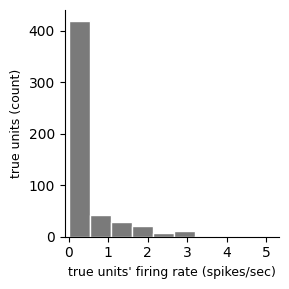

In [262]:
# Create a histogram with binning for the x-axis
sns.displot(data=score_by_rates, x='firing rate', bins=n_bins, kde=False, height=3, aspect=1, color=(0.3,0.3,0.3), edgecolor="w");
plt.xlabel("true units' firing rate (spikes/sec)", fontsize=9);
plt.ylabel("true units (count)", fontsize=9);
plt.ylabel("true units (count)", fontsize=9);
plt.xlim([-0.1, max_rate+0.01]);
plt.xticks(np.arange(0,max_rate,1));

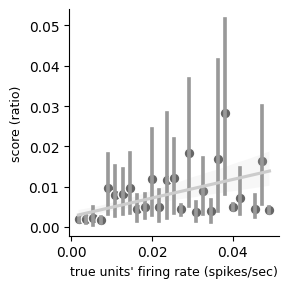

In [265]:
sns.lmplot(x="firing rate", y="score", data=score_by_rates[score_by_rates["firing rate"]<0.05], x_estimator=np.mean, height=3, aspect=1,
           scatter_kws={"s":60, "edgecolor":"w", "facecolor":(0.4,0.4,0.4), "color":(0.6,0.6,0.6)}, line_kws={"color":(0.8,0.8,0.8)});

plt.xlabel("true units' firing rate (spikes/sec)", fontsize=9);
plt.ylabel("score (ratio)", fontsize=9);

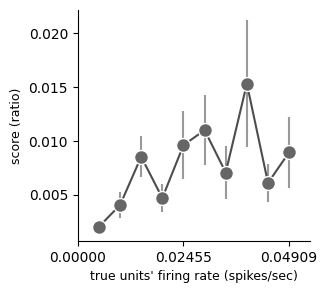

In [279]:
fig, ax = plt.subplots(1,1, figsize=(3,3))

subset_score_by_rates = score_by_rates[score_by_rates["firing rate"]<0.05]

# get bins
n_bins = 10

# round max snr to the neareast 10b
max_rate = subset_score_by_rates["firing rate"].max()
bin_size = max_rate/n_bins
bins = np.arange(0, max_rate + bin_size, bin_size)
bins

# get rate bin indices
df_cut = pd.cut(subset_score_by_rates["firing rate"],  bins=bins, labels=bins[1:], retbins=True)
binned_score_by_rates = pd.DataFrame(data={"firing rate": df_cut[0], "score": subset_score_by_rates["score"]})

# calculate p(misses) and its variance by snr
pmisses_by_snr = binned_score_by_rates.groupby("firing rate").mean()
varmisses_by_snr = binned_score_by_rates.groupby("firing rate").sem()

# plot miss ratios by snr
ax.errorbar(x=list(
    pmisses_by_snr.index), y=pmisses_by_snr["score"].values.tolist(), yerr=varmisses_by_snr["score"].values.tolist(),
    marker="o", markersize=10, markeredgecolor="w", markerfacecolor=(0.4,0.4,0.4), ecolor=(0.6,0.6,0.6), color=(0.3,0.3,0.3)
    );
ax.spines[["right", "top"]].set_visible(False)
ax.set_xlabel("true units' firing rate (spikes/sec)", fontsize=9);
ax.set_ylabel("score (ratio)", fontsize=9);
ax.set_xlim([0, 1.1*max_rate]);
ax.set_xticks([0, max_rate/2, max_rate]);

In [283]:
print("units in subsample (count):", subset_score_by_rates.shape[0])

units in subsample (count): 277
